In [1]:
# import libraries

# exploring and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

print(tf.__version__)

2.13.0


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-10-19 11:43:34--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  2.23MB/s    in 0.2s    

2023-10-19 11:43:35 (2.23 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-10-19 11:43:35--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [3]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['label', 'message'])
df_train.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [4]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['label', 'message'])
df_test.head()

,label,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [5]:
print(len(df_train))
print(len(df_test))
# imbalanced!

4179
1392


## 1. Preprocess the data

In [6]:
# transform categorical data
y_train = df_train['label'].map( {'spam': 1, 'ham': 0})
y_test  = df_test['label'].map( {'spam': 1, 'ham': 0})
y_train[:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

Text(0.5, 1.0, 'Number of ham and spam messages')

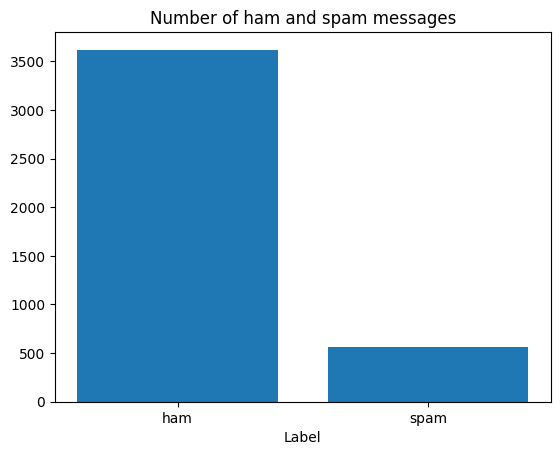

In [7]:
bar = df_train['label'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [8]:
# preprocess the text
nltk.download('stopwords')
nltk.download('wordnet')   # vocab for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

179

In [10]:
# function for lemmatising and stopword removal
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt) # remove symbols
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [11]:
# apply function to training data
X_train = df_train['message'].apply(lambda x: clean_txt(x))
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: message, dtype: object

In [12]:
# vectorise
# set params
VOCAB_SIZE  = 1000

max_len = 100 # set max len to 100 bc sms data

In [13]:
# apply tokeniser to training data
t = Tokenizer(num_words=VOCAB_SIZE)
t.fit_on_texts(X_train)

In [14]:
# Transform each text to a sequence of integers
sequences_train = t.texts_to_sequences(X_train) # use to interpret tokens as categorical data; but not as efficient as word embeddings!
sequences_train[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [15]:
# padding to get the same length for all sequences
padded_train = pad_sequences(sequences_train, maxlen=max_len,)
print(padded_train)

[[  0   0   0 ...  54 228  86]
 [  0   0   0 ...   0 195 252]
 [  0   0   0 ...   6 338 422]
 ...
 [  0   0   0 ...  71  51 100]
 [  0   0   0 ...  35 611 954]
 [  0   0   0 ...  40  17 108]]


## 2. Build the model

In [16]:
i = tf.keras.layers.Input(shape=[max_len])
x = tf.keras.layers.Embedding(VOCAB_SIZE, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(64)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96337 (376.32 KB)
Trainable params: 96337 (376.

In [17]:
class_weights = { # weight classes to handle the imbalanced dataset
    0: 1.0,  # class weight for ham (majority class)
    1: 3.0  # class weight for spam (minority class)
}

res = model.fit(padded_train, y_train,
              batch_size=64, epochs=10,
              validation_split=0.2,
              class_weight=class_weights,
              callbacks=[tf.keras.callbacks.EarlyStopping( # early stopping to prevent overfitting
                  monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
53/53 [==============================] - 17s 116ms/step - loss: 1.7865 - accuracy: 0.8178 - val_loss: 0.2499 - val_accuracy: 0.9809
Epoch 2/10
53/53 [==============================] - 5s 91ms/step - loss: 0.1888 - accuracy: 0.9838 - val_loss: 0.1179 - val_accuracy: 0.9880
Epoch 3/10
53/53 [==============================] - 2s 39ms/step - loss: 0.1402 - accuracy: 0.9865 - val_loss: 0.1031 - val_accuracy: 0.9904
Epoch 4/10
53/53 [==============================] - 1s 24ms/step - loss: 0.1437 - accuracy: 0.9910 - val_loss: 0.1046 - val_accuracy: 0.9856


## 3. Evaluation

In [18]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

In [19]:
s = model.evaluate(preprocessing(df_test['message']), y_test)

44/44 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.9856


## 4. Test

In [20]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 353ms/step
(0.0, 'ham')


In [21]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print(predict_message(msg))
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 22ms/step
(0.0, 'ham')
1/1 [==============================] - 0s 18ms/step
(0.68576413, 'spam')
1/1 [==============================] - 0s 19ms/step
(0.0, 'ham')
1/1 [==============================] - 0s 19ms/step
(1.3875643, 'spam')
1/1 [==============================] - 0s 24ms/step
(2.0254266, 'spam')
1/1 [==============================] - 0s 21ms/step
(0.0, 'ham')
1/1 [==============================] - 0s 18ms/step
(0.0, 'ham')
You passed the challenge. Great job!
